<a href="https://colab.research.google.com/github/dedkoster/AI_competitions/blob/master/sberbank_covid19_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Подключаем библиотеки и загружаем данные

In [1]:
!pip install catboost

     |████████████████████████████████| 64.8MB 63kB/s 


In [0]:
from sklearn import ensemble, model_selection, datasets, metrics, tree, linear_model, preprocessing 
from sklearn.neural_network import MLPRegressor

from catboost import CatBoostRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import lightgbm as lgb

import xgboost as xgb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
%matplotlib inline

## Данные по заражениям

In [5]:
!git clone https://github.com/CSSEGISandData/COVID-19 -b web-data COVID-19-new

Cloning into 'COVID-19-new'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 22611 (delta 10), reused 17 (delta 9), pack-reused 22584
Receiving objects: 100% (22611/22611), 98.62 MiB | 38.47 MiB/s, done.
Resolving deltas: 100% (12247/12247), done.


In [6]:
!git clone https://github.com/CSSEGISandData/COVID-19.git


Cloning into 'COVID-19'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 22611 (delta 10), reused 17 (delta 9), pack-reused 22584
Receiving objects: 100% (22611/22611), 98.81 MiB | 36.62 MiB/s, done.
Resolving deltas: 100% (12244/12244), done.


In [7]:
!git clone https://github.com/grwlf/COVID-19_plus_Russia.git

Cloning into 'COVID-19_plus_Russia'...
remote: Enumerating objects: 17561, done.
remote: Total 17561 (delta 0), reused 0 (delta 0), pack-reused 17561
Receiving objects: 100% (17561/17561), 83.48 MiB | 39.69 MiB/s, done.
Resolving deltas: 100% (8923/8923), done.


## Данные про страны

In [8]:
!git clone https://github.com/vlomme/sberbank-covid19-forecast-2020.git

Cloning into 'sberbank-covid19-forecast-2020'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 232 (delta 24), reused 0 (delta 0), pack-reused 193
Receiving objects: 100% (232/232), 7.53 MiB | 26.58 MiB/s, done.
Resolving deltas: 100% (118/118), done.


## Данные по карантинам

In [9]:
!git clone https://github.com/tyz910/sberbank-covid19.git

Cloning into 'sberbank-covid19'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 160 (delta 73), reused 143 (delta 56), pack-reused 0
Receiving objects: 100% (160/160), 1.17 MiB | 16.35 MiB/s, done.
Resolving deltas: 100% (73/73), done.


## Загружаем данные

In [10]:
today = pd.to_datetime('today').strftime("%Y-%m-%d")
#Загрузить список стран и удалить лишние атрибуты 
countries = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/countries.csv")
countries.drop(['iso_alpha2','iso_numeric','official_name','name'], axis='columns',inplace=True)

#Загрузить список регионов
regions = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/russia_regions.csv")
regions = regions[["iso_code","csse_province_state","population","population_urban"]]
regions.population_urban = regions.population_urban/regions.population
regions.rename(columns={"iso_code": "iso_alpha3","csse_province_state":"ccse_name","population_urban":"urban_pop_rate"},inplace=True)
countries = pd.concat([countries, regions])

#Загрузить список стран c датами
data_ans = pd.read_csv("/content/sberbank-covid19-forecast-2020/sample_submission.csv").iloc[:,:-1]
data_ans["confirmed"] = -1
data_ans = data_ans.merge(countries, how = 'left', left_on='region', right_on='iso_alpha3')
data_ans = data_ans[["date","ccse_name","confirmed"]]
data_ans = data_ans.rename(columns={"ccse_name": "countries"})
data_ans["deaths"] = 0
data_ans["recovered"] = 0
data_ans = data_ans[data_ans.date >= today]

#Загрузить данные заражений по миру
data = pd.read_csv("/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
data = data.groupby("Country/Region").sum()

#Загрузить данные смертей по миру
data_deaths = pd.read_csv("/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
data_deaths = data_deaths.groupby("Country/Region").sum()

#Загрузить данные заражений по России
data_Ru = pd.read_csv("/content/COVID-19_plus_Russia/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_RU.csv").groupby("Province_State").sum()
data_Ru = data_Ru.iloc[:,15:].stack().reset_index()
data_Ru.columns = ["countries","date","confirmed"]
#Загрузить данные смертей по России
data_deaths_Ru = pd.read_csv("/content/COVID-19_plus_Russia/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_RU.csv").groupby("Province_State").sum()
data_deaths_Ru = data_deaths_Ru.iloc[:,15:].stack().reset_index()
data_deaths_Ru.columns = ["countries","date","deaths"]
data_Ru = data_Ru.merge(data_deaths_Ru, how = 'left', left_on=('countries','date'), right_on=('countries','date'))
data_Ru["recovered"] = 0

#Каждый день на новой строке
data_deaths = data_deaths.iloc[:,4:].stack().reset_index()
data_deaths.columns = ["countries","date","deaths"]

#Загрузить данные смертей по миру
data_recovered = pd.read_csv("/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
data_recovered = data_recovered.groupby("Country/Region").sum()
data_recovered = data_recovered.iloc[:,4:].stack().reset_index()
data_recovered.columns = ["countries","date","recovered"]
data_recovered["recovered"] = np.log10(data_recovered["recovered"]+1)

#Карантин
data_quarantine = pd.read_csv("/content/sberbank-covid19/data/quarantine.csv")
data_quarantine = data_quarantine.groupby("country").max().loc[:,"date"]
countries = countries.set_index("iso_alpha3", drop=False)
countries["Quarantine"] = data_quarantine
countries = countries.rename(columns={"ccse_name": "countries"})
dic_countries = dict(zip(countries.iso_alpha3.to_list(), countries.countries.to_list()))

# Сегоднящние данные
countries_today = pd.read_csv("/content/COVID-19-new/data/cases_country.csv")
countries_today["Last_Update"] = pd.to_datetime(countries_today["Last_Update"]).apply(lambda x: pd.Series(x.strftime("%Y-%m-%d")))
countries_today = countries_today[["Country_Region","Last_Update","Confirmed","Deaths","Recovered"]]
countries_today.columns = ['countries', 'date', 'confirmed', 'deaths', 'recovered']
countries_today.recovered =  np.log10(countries_today["recovered"]+1)
countries_today = countries_today[countries_today.countries.isin(countries.countries.to_list())]
countries_today = countries_today.sort_values(by='countries')

#Здравохранение
Health_systems = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/2.12_Health_systems.csv").groupby("Country_Region").mean()
Health_systems = Health_systems.fillna(Health_systems.mean())
Health_systems = Health_systems[["Health_exp_pct_GDP_2016","Health_exp_per_capita_USD_2016","Physicians_per_1000_2009-18","Nurse_midwife_per_1000_2009-18"]]
Health_systems.columns = ["Health_GDP","Health_USD","Physicians","Nurse"]
countries = countries.merge(Health_systems, how = 'left', left_on='countries', right_on='Country_Region')

#Возраст
WorldPop = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/WorldPopulationByAge2020.csv")
WorldPop = WorldPop.fillna(WorldPop.mean())
WorldPop2 = (WorldPop[WorldPop["AgeGrp"]=="60+"]["PopTotal"].to_numpy() + WorldPop[WorldPop["AgeGrp"]=="40-59"]["PopTotal"].to_numpy())/(WorldPop[WorldPop["AgeGrp"]=="0-19"]["PopTotal"].to_numpy()+WorldPop[WorldPop["AgeGrp"]=="20-39"]["PopTotal"].to_numpy())
WorldPop = WorldPop.groupby("Location").mean()
WorldPop["Age_old/new"] = WorldPop2
WorldPop = WorldPop[["Age_old/new"]].reset_index()
countries = countries.merge(WorldPop, how = 'left', left_on='countries', right_on='Location')

#Курение
smoke = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/share-of-adults-who-smoke.csv")
smoke = smoke[smoke.Year > 2015].groupby("Entity").mean()
smoke = smoke[["Smoking prevalence, total (ages 15+) (% of adults)"]]
smoke.columns = ["Smoking"]
smoke = smoke.reset_index()
countries= countries.merge(smoke, how = 'left', left_on='countries', right_on='Entity')
countries.drop(['Entity','Location'], axis='columns',inplace=True)

#Еще инфа о странах
countries2 = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/covid19countryinfo.csv")
countries2 = countries2.fillna(0).groupby("country").sum()
countries2 = countries2[["tests","testpop","gatheringlimit","hospibed","healthperpop"]]
countries = countries.merge(countries2, how = 'left', left_on='countries', right_on='country')

# Избавляемся от Nan
countries_mean = countries.mean()
countries.loc[countries.tests == 0,"tests"] = countries.tests.mean()
countries.loc[countries.testpop == 0,"testpop"] = countries.testpop.mean()
countries.loc[countries.gatheringlimit == 0,"gatheringlimit"] = countries.gatheringlimit.mean()
countries.loc[countries.hospibed == 0,"hospibed"] = countries.hospibed.mean()
countries['fertility_rate'] = countries['fertility_rate'].fillna(countries_mean['fertility_rate'])
countries['median_age'] = countries['median_age'].fillna(countries_mean['median_age'])
countries['migrants'] = countries['migrants'].fillna(countries_mean['migrants'])
countries['urban_pop_rate'] = countries['urban_pop_rate'].fillna(countries_mean['urban_pop_rate'])
countries['Age_old/new'] = countries['Age_old/new'].fillna(countries_mean['Age_old/new'])
countries['Smoking'] = countries['Smoking'].fillna(countries_mean['Smoking'])
countries['Health_GDP'] = countries['Health_GDP'].fillna(countries_mean['Health_GDP'])
countries['Health_USD'] = countries['Health_USD'].fillna(countries_mean['Health_USD'])
countries['Physicians'] = countries['Physicians'].fillna(countries_mean['Physicians'])
countries['Nurse'] = countries['Nurse'].fillna(countries_mean['Nurse'])
countries['tests'] = countries['tests'].fillna(countries_mean['tests'])
countries['testpop'] = countries['testpop'].fillna(countries_mean['testpop'])
countries['gatheringlimit'] = countries['gatheringlimit'].fillna(countries_mean['gatheringlimit'])
countries['hospibed'] = countries['hospibed'].fillna(countries_mean['hospibed'])
countries['healthperpop'] = countries['healthperpop'].fillna(countries_mean['healthperpop'])
countries['Quarantine'] = countries['Quarantine'].fillna("2020-04-10")
countries['density'] = countries['density'].fillna(countries_mean['density'])
countries['land_area'] = countries['land_area'].fillna(countries_mean['land_area'])
countries['world_share'] = countries['world_share'].fillna(countries_mean['world_share'])

#mobility
mobility = pd.read_csv("/content/sberbank-covid19/data/mobility-google.csv")
mobility.columns = ["country","date","Parks","Residential","Retail & recreation","Transit stations","Workplaces","Grocery & pharmacy"]
mobility["date"] = pd.to_datetime(mobility.date)

#Страна в строку. Каждый день это столбец
data_all = countries.merge(data, how = 'left', left_on='countries', right_on='Country/Region')
data_all.head()

,iso_alpha3,countries,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,Quarantine,Health_GDP,Health_USD,Physicians,Nurse,Age_old/new,Smoking,tests,testpop,gatheringlimit,hospibed,healthperpop,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20
0,AFG,Afghanistan,60.0,4.600000,652860.0,18.000000,-62920.00000,38928346,0.25,0.0050,2020-04-10,10.2,57.2,0.3,0.3,0.198312,21.3088,9401.383234,6937.96288,18.532934,0.500000,4.726633,33.0000,65.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,22.0,22.0,24.0,24.0,40.0,40.0,74.0,84.0,94.0,110.0,110.0,120.0,170.0,174.0,237.0,273.0,281.0,299.0,349.0,367.0,423.0,444.0,484.0,521.0,555.0,607.0,665.0,714.0,784.0,840.0,906.0,933.0,996.0,1026.0,1092.0,1176.0,1279.0,1351.0,1463.0
1,ALB,Albania,105.0,1.600000,27400.0,36.000000,-14000.00000,2877797,0.63,0.0004,2020-03-13,6.7,271.5,1.2,3.6,0.842682,28.7000,9401.383234,6937.96288,18.532934,2.900000,268.955733,41.1533,20.1683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55.0,59.0,64.0,70.0,76.0,89.0,104.0,123.0,146.0,174.0,186.0,197.0,212.0,223.0,243.0,259.0,277.0,304.0,333.0,361.0,377.0,383.0,400.0,409.0,416.0,433.0,446.0,467.0,475.0,494.0,518.0,539.0,548.0,562.0,584.0,609.0,634.0,663.0,678.0,712.0
2,DZA,Algeria,18.0,3.100000,2381740.0,29.000000,-10000.00000,43851044,0.73,0.0056,2020-03-23,6.6,260.4,1.8,2.2,0.448944,15.6000,9401.383234,6937.96288,18.532934,1.900000,23.511413,28.0339,1.6596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,60.0,74.0,87.0,90.0,139.0,201.0,230.0,264.0,302.0,367.0,409.0,454.0,511.0,584.0,716.0,847.0,986.0,1171.0,1251.0,1320.0,1423.0,1468.0,1572.0,1666.0,1761.0,1825.0,1914.0,1983.0,2070.0,2160.0,2268.0,2418.0,2534.0,2629.0,2718.0,2811.0,2910.0,3007.0,3127.0,3256.0
3,AND,Andorra,164.0,2.600613,470.0,31.134969,3353.02454,77265,0.88,0.0000,2020-04-10,10.4,3834.7,3.3,4.0,0.638559,33.5000,9401.383234,6937.96288,18.532934,2.500000,76994.758300,42.5063,1.5218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.0,39.0,53.0,75.0,88.0,113.0,133.0,164.0,188.0,224.0,267.0,308.0,334.0,370.0,376.0,390.0,428.0,439.0,466.0,501.0,525.0,545.0,564.0,583.0,601.0,601.0,638.0,646.0,659.0,673.0,673.0,696.0,704.0,713.0,717.0,717.0,723.0,723.0,731.0,738.0
4,AGO,Angola,26.0,5.600000,1246700.0,17.000000,6413.00000,32866272,0.67,0.0042,2020-04-10,2.9,95.2,0.2,1.3,0.182404,21.3088,9401.383234,6937.96288,18.532934,3.479572,2416.414936,-11.2027,17.8739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,5.0,7.0,7.0,7.0,8.0,8.0,8.0,10.0,14.0,16.0,17.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,24.0,24.0,24.0,24.0,25.0,25.0,25.0,25.0


## Смотрим на первые страны

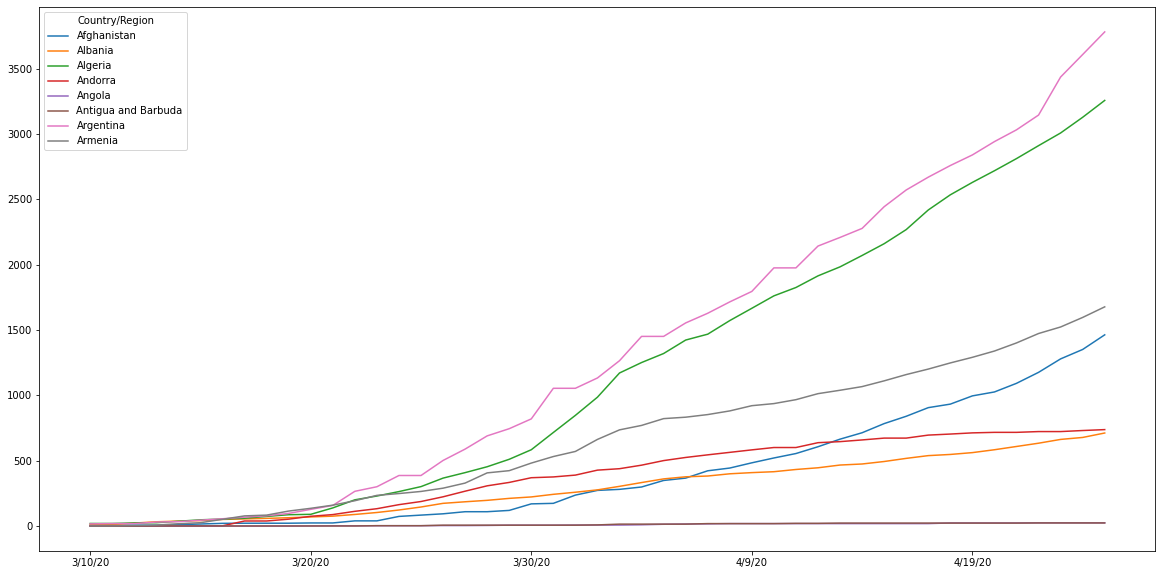

In [11]:
plt.rcParams['figure.figsize'] = [20, 10]
data.iloc[:8].T.iloc[50:].plot()

# Обрабатываем данные

## Представляем данные в виде, где каждой дате соответствует свой столбец

In [0]:
data2 = data.iloc[:,4:].stack().reset_index()
data2.columns = ["countries","date","confirmed"]

#Соединим смерти и заражения
data2 = data2.merge(data_deaths, how = 'left', left_on=('countries','date'), right_on=('countries','date'))

# Добавим выздоровивших
data2 = data2.merge(data_recovered, how = 'left', left_on=('countries','date'), right_on=('countries','date'))
data2 = data2[data2.countries.isin(countries.countries.to_list())]

#Объединим с сегодня
last_confirmed = data2.loc[pd.to_datetime(data2.date) == pd.to_datetime(today) - pd.offsets.Day(1)].sort_values(by='countries')
countries_today_new = countries_today[countries_today.confirmed.values > last_confirmed.confirmed.values]
data2 = pd.concat([data2, countries_today_new],ignore_index=True)

#Добавим Россию
data2 = pd.concat([data2, data_Ru],ignore_index=True)

#Объединим с будущим
data_ans = data_ans[(data_ans.date != today)|~(data_ans.countries.isin(countries_today_new.countries.values))]
data2 = pd.concat([data2, data_ans],ignore_index=True)


#Добавим информацию о стране(плотность, население и тд)
data2 = data2.merge(countries, how = 'right', left_on='countries', right_on='countries')

#Удалим дни без больных
data2 = data2[data2.confirmed != 0]
data2.loc[data2.confirmed == -1,"confirmed"] = 0
data2 = data2[data2.iso_alpha3 != "RU-AL"]


data2["date"] = pd.to_datetime(data2.date)
data2 = data2.merge(mobility, how = 'left', left_on=('iso_alpha3','date'), right_on=('country','date'))
mobility_min = mobility.groupby("country").min().drop(['date'], axis='columns')
mobility_min.columns = ['min_Retail & recreation', 'min_Grocery & pharmacy', 'min_Parks',
       'min_Transit stations', 'min_Workplaces', 'min_Residential']
data2 = data2.merge(mobility_min, how = 'left', left_on='iso_alpha3', right_on='country')
data2.loc[data2.Parks.isnull(),['Retail & recreation', 'Grocery & pharmacy', 'Parks',
       'Transit stations', 'Workplaces', 'Residential']] = data2.loc[data2.Parks.isnull(),['min_Retail & recreation', 'min_Grocery & pharmacy', 'min_Parks',
       'min_Transit stations', 'min_Workplaces', 'min_Residential']].to_numpy()
data2.drop(['country', 'min_Retail & recreation', 'min_Grocery & pharmacy', 'min_Parks',
       'min_Transit stations', 'min_Workplaces', 'min_Residential'], axis='columns',inplace=True)
data2[['Retail & recreation', 'Grocery & pharmacy', 'Parks',
       'Transit stations', 'Workplaces', 'Residential']] = data2[['Retail & recreation', 'Grocery & pharmacy', 'Parks',
       'Transit stations', 'Workplaces', 'Residential']].fillna(data2[['Retail & recreation', 'Grocery & pharmacy', 'Parks',
       'Transit stations', 'Workplaces', 'Residential']].mean())

In [0]:
data2.confirmed = data2.confirmed/10**4
data2.deaths = data2.deaths/10**3

## Добавляем признак, количество дней от первого зараженного

In [14]:
data2

,countries,date,confirmed,deaths,recovered,iso_alpha3,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,Quarantine,Health_GDP,Health_USD,Physicians,Nurse,Age_old/new,Smoking,tests,testpop,gatheringlimit,hospibed,healthperpop,Parks,Residential,Retail & recreation,Transit stations,Workplaces,Grocery & pharmacy
0,Afghanistan,2020-02-24,0.0001,0.0,0.0,AFG,60.000000,4.600000,652860.000000,18.000000,-62920.00000,38928346,0.250000,0.005000,2020-04-10,10.200000,57.200000,0.300000,0.300000,0.198312,21.3088,9401.383234,6937.96288,18.532934,0.500000,4.726633,2.000000,0.000000,2.000000,9.000000,7.000000,6.000000
1,Afghanistan,2020-02-25,0.0001,0.0,0.0,AFG,60.000000,4.600000,652860.000000,18.000000,-62920.00000,38928346,0.250000,0.005000,2020-04-10,10.200000,57.200000,0.300000,0.300000,0.198312,21.3088,9401.383234,6937.96288,18.532934,0.500000,4.726633,2.000000,1.000000,0.000000,5.000000,6.000000,5.000000
2,Afghanistan,2020-02-26,0.0001,0.0,0.0,AFG,60.000000,4.600000,652860.000000,18.000000,-62920.00000,38928346,0.250000,0.005000,2020-04-10,10.200000,57.200000,0.300000,0.300000,0.198312,21.3088,9401.383234,6937.96288,18.532934,0.500000,4.726633,1.000000,2.000000,-1.000000,3.000000,7.000000,2.000000
3,Afghanistan,2020-02-27,0.0001,0.0,0.0,AFG,60.000000,4.600000,652860.000000,18.000000,-62920.00000,38928346,0.250000,0.005000,2020-04-10,10.200000,57.200000,0.300000,0.300000,0.198312,21.3088,9401.383234,6937.96288,18.532934,0.500000,4.726633,1.000000,2.000000,-2.000000,4.000000,6.000000,3.000000
4,Afghanistan,2020-02-28,0.0001,0.0,0.0,AFG,60.000000,4.600000,652860.000000,18.000000,-62920.00000,38928346,0.250000,0.005000,2020-04-10,10.200000,57.200000,0.300000,0.300000,0.198312,21.3088,9401.383234,6937.96288,18.532934,0.500000,4.726633,0.000000,2.000000,-1.000000,4.000000,6.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32908,Zabaykalskiy kray,2020-07-14,0.0000,0.0,0.0,RU-ZAB,382.272189,2.600613,737651.118343,31.134969,3353.02454,1059657,0.681972,0.005746,2020-04-10,6.469996,1141.890047,1.869306,4.364826,0.638559,21.3088,9401.383234,6937.96288,18.532934,3.479572,2416.414936,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816
32909,Zabaykalskiy kray,2020-07-15,0.0000,0.0,0.0,RU-ZAB,382.272189,2.600613,737651.118343,31.134969,3353.02454,1059657,0.681972,0.005746,2020-04-10,6.469996,1141.890047,1.869306,4.364826,0.638559,21.3088,9401.383234,6937.96288,18.532934,3.479572,2416.414936,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816
32910,Zabaykalskiy kray,2020-07-16,0.0000,0.0,0.0,RU-ZAB,382.272189,2.600613,737651.118343,31.134969,3353.02454,1059657,0.681972,0.005746,2020-04-10,6.469996,1141.890047,1.869306,4.364826,0.638559,21.3088,9401.383234,6937.96288,18.532934,3.479572,2416.414936,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816
32911,Zabaykalskiy kray,2020-07-17,0.0000,0.0,0.0,RU-ZAB,382.272189,2.600613,737651.118343,31.134969,3353.02454,1059657,0.681972,0.005746,2020-04-10,6.469996,1141.890047,1.869306,4.364826,0.638559,21.3088,9401.383234,6937.96288,18.532934,3.479572,2416.414936,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816


In [15]:
# Считаем дни от первого больного

#data2 = data2[(data2["date"]<pd.to_datetime("2020-05-1")) & ((data2["date"]>pd.to_datetime("2020-04-1")) | (data2.confirmed !=-1))]
data4 = data2[["countries","date"]].groupby("countries").min()
data4.columns = ["Date_min"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2["days"] = (data2.date - data2.Date_min).dt.days

data2["days_mart"] = (data2.date - pd.to_datetime("2020-03-1")).dt.days
data2["days_after_Quarantine"] = (data2.date - pd.to_datetime(data2.Quarantine)).dt.days
data2.drop(['Date_min'], axis='columns',inplace=True)
data2.date = data2["date"].apply(lambda x: pd.Series(x.strftime("%m-%d")))
#data2 = data2.dropna(axis='index', how='any')
data2[data2.iso_alpha3 == "RUS"].iloc[70:75]

,countries,date,confirmed,deaths,recovered,iso_alpha3,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,Quarantine,Health_GDP,Health_USD,Physicians,Nurse,Age_old/new,Smoking,tests,testpop,gatheringlimit,hospibed,healthperpop,Parks,Residential,Retail & recreation,Transit stations,Workplaces,Grocery & pharmacy,days,days_mart,days_after_Quarantine
17985,Russia,04-10,1.1917,0.094,2.900913,RUS,9.0,1.8,16376870.0,40.0,182456.0,145934462,0.74,0.0187,2020-03-30,5.3,469.1,4.0,8.6,0.638559,39.3,116061.0,1257.394491,18.532934,8.2,9.689281,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816,70,40,11
17986,Russia,04-11,1.3584,0.106,3.019532,RUS,9.0,1.8,16376870.0,40.0,182456.0,145934462,0.74,0.0187,2020-03-30,5.3,469.1,4.0,8.6,0.638559,39.3,116061.0,1257.394491,18.532934,8.2,9.689281,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816,71,41,12
17987,Russia,04-12,1.5770,0.130,3.111263,RUS,9.0,1.8,16376870.0,40.0,182456.0,145934462,0.74,0.0187,2020-03-30,5.3,469.1,4.0,8.6,0.638559,39.3,116061.0,1257.394491,18.532934,8.2,9.689281,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816,72,42,13
17988,Russia,04-13,1.8328,0.148,3.167613,RUS,9.0,1.8,16376870.0,40.0,182456.0,145934462,0.74,0.0187,2020-03-30,5.3,469.1,4.0,8.6,0.638559,39.3,116061.0,1257.394491,18.532934,8.2,9.689281,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816,73,43,14
17989,Russia,04-14,2.1102,0.170,3.229170,RUS,9.0,1.8,16376870.0,40.0,182456.0,145934462,0.74,0.0187,2020-03-30,5.3,469.1,4.0,8.6,0.638559,39.3,116061.0,1257.394491,18.532934,8.2,9.689281,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816,74,44,15


## Добавить данные за прошлый день

In [16]:
old_con = data2["confirmed"].iloc[:-1]
old_con2 = data2["deaths"].iloc[:-1]
old_recovered = data2["recovered"].iloc[:-1]
data2 = data2.iloc[1:]
data2["pred_conf"] = old_con.values
data2["pred_deaths"] = old_con2.values
data2["pred_recovered"] = old_recovered.values

data2 = data2.iloc[1:]
data2["delta_conf1"] = old_con.values[1:] - old_con.values[:-1]
data2["delta_deaths1"] = old_con2.values[1:] - old_con2.values[:-1]
data2 = data2.iloc[1:]
data2["delta_conf2"] = old_con.values[1:-1] - old_con.values[:-2]
data2["delta_deaths2"] = old_con2.values[1:-1] - old_con2.values[:-2]
data2[data2.iso_alpha3 == "RUS"].iloc[70:75]

,countries,date,confirmed,deaths,recovered,iso_alpha3,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,Quarantine,Health_GDP,Health_USD,Physicians,Nurse,Age_old/new,Smoking,tests,testpop,gatheringlimit,hospibed,healthperpop,Parks,Residential,Retail & recreation,Transit stations,Workplaces,Grocery & pharmacy,days,days_mart,days_after_Quarantine,pred_conf,pred_deaths,pred_recovered,delta_conf1,delta_deaths1,delta_conf2,delta_deaths2
17985,Russia,04-10,1.1917,0.094,2.900913,RUS,9.0,1.8,16376870.0,40.0,182456.0,145934462,0.74,0.0187,2020-03-30,5.3,469.1,4.0,8.6,0.638559,39.3,116061.0,1257.394491,18.532934,8.2,9.689281,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816,70,40,11,1.0131,0.076,2.844477,0.1459,0.013,0.1175,0.005
17986,Russia,04-11,1.3584,0.106,3.019532,RUS,9.0,1.8,16376870.0,40.0,182456.0,145934462,0.74,0.0187,2020-03-30,5.3,469.1,4.0,8.6,0.638559,39.3,116061.0,1257.394491,18.532934,8.2,9.689281,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816,71,41,12,1.1917,0.094,2.900913,0.1786,0.018,0.1459,0.013
17987,Russia,04-12,1.5770,0.130,3.111263,RUS,9.0,1.8,16376870.0,40.0,182456.0,145934462,0.74,0.0187,2020-03-30,5.3,469.1,4.0,8.6,0.638559,39.3,116061.0,1257.394491,18.532934,8.2,9.689281,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816,72,42,13,1.3584,0.106,3.019532,0.1667,0.012,0.1786,0.018
17988,Russia,04-13,1.8328,0.148,3.167613,RUS,9.0,1.8,16376870.0,40.0,182456.0,145934462,0.74,0.0187,2020-03-30,5.3,469.1,4.0,8.6,0.638559,39.3,116061.0,1257.394491,18.532934,8.2,9.689281,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816,73,43,14,1.5770,0.130,3.111263,0.2186,0.024,0.1667,0.012
17989,Russia,04-14,2.1102,0.170,3.229170,RUS,9.0,1.8,16376870.0,40.0,182456.0,145934462,0.74,0.0187,2020-03-30,5.3,469.1,4.0,8.6,0.638559,39.3,116061.0,1257.394491,18.532934,8.2,9.689281,-56.198741,-35.293563,-48.283638,-60.773842,-55.293111,-5.621816,74,44,15,1.8328,0.148,3.167613,0.2558,0.018,0.2186,0.024


## Масштабируем признаки

In [0]:
sc_days = 100
data2.density = data2.density/data2.density.max()
data2.fertility_rate = data2.fertility_rate/data2.fertility_rate.max()
data2.land_area = np.log10(data2.land_area+1)
data2.land_area = data2.land_area/data2.land_area.max()
data2.median_age = data2.median_age/data2.median_age.max()
data2.migrants = data2.migrants - data2.migrants.min()
data2.migrants = np.log10(data2.migrants+1)
data2.migrants = data2.migrants/data2.migrants.max()
data2.population = data2.population/data2.population.max()
data2.Health_GDP = data2.Health_GDP/data2.Health_GDP.max()
data2.Health_USD = data2.Health_USD/data2.Health_USD.max()
data2.Physicians = data2.Physicians/data2.Physicians.max()
data2.tests = data2.tests/data2.tests.max()
data2.testpop = data2.testpop/data2.testpop.max()
data2.gatheringlimit = data2.gatheringlimit/data2.gatheringlimit.max()
data2.hospibed = data2.hospibed/data2.hospibed.max()
data2.healthperpop = data2.healthperpop/data2.healthperpop.max()
data2['Retail & recreation'] = data2['Retail & recreation']/sc_days
data2['Grocery & pharmacy'] = data2['Grocery & pharmacy']/sc_days
data2['Parks'] = data2['Parks']/sc_days
data2['Transit stations'] = data2['Transit stations']/sc_days
data2['Workplaces'] = data2['Workplaces']/sc_days
data2['Residential'] = data2['Residential']/sc_days
data2.Nurse = data2.Nurse/data2.Nurse.max()
data2["Age_old/new"] = data2["Age_old/new"]/data2["Age_old/new"].max()
data2.Smoking = data2.Smoking/50
data2.days = data2.days/sc_days
data2.days_mart = data2.days_mart/sc_days
data2.days_after_Quarantine = data2.days_after_Quarantine/sc_days


# Отделяем данные на трейн и тест

In [0]:
#Выберите день начала приватных данных начиная с 1 марта
days_x = 40 #43


param_list =['countries', 'confirmed', 'deaths', 'iso_alpha3', 
              'pred_conf', 'pred_deaths', 
             'Transit stations',
             'testpop',
             'Workplaces',
             'Health_GDP',
             'Physicians', 
             'urban_pop_rate',             
             'hospibed',
             'Nurse',
             'Parks',
             'tests',
             'population',
             'gatheringlimit',

             'Grocery & pharmacy', 
             'Residential',
             'world_share',
             'fertility_rate', 
             'migrants', 

             'land_area',
             'healthperpop',
             'Retail & recreation',
             'Age_old/new', 
             'Health_USD', 
             'median_age',             
             'Smoking', 
             'density',
             
             'pred_recovered',
             'recovered',
             'days',
             'days_after_Quarantine', 

              
             'delta_conf1', 
             'delta_deaths1',
             'delta_conf2', 
             'delta_deaths2',
             'days_mart']

data3 = data2[param_list]

In [19]:
model_Confirmed, model_Death = {}, {}

#Представляем страны в one_hot
#one_hot = pd.get_dummies(data3['iso_alpha3'])
#data3 = data3.join(one_hot)

#Отделяем пару стран на тест
data_Korea = data3[(data3.countries == 'Korea, South') & (data3.confirmed > 0)]
data_Russia = data3[(data3.countries == 'Russia') & (data3.confirmed > 0)]

#Приватные данные
new_data = data3[data3.days_mart >= (days_x)/sc_days]
data_x = data3[data3.days_mart == (days_x-1)/sc_days]
old_data = data3[(data3.days_mart < (days_x)/sc_days) & (data3.confirmed > 0)]
old_data = old_data[(old_data.countries != 'Russia')&(old_data.countries != 'Korea, South')]

train_labels = old_data.confirmed
train_death = old_data.deaths

#Убираем ответ из данных
train_data = old_data.drop(['iso_alpha3','confirmed','countries','deaths'], axis='columns')
train_data

,pred_conf,pred_deaths,Transit stations,testpop,Workplaces,Health_GDP,Physicians,urban_pop_rate,hospibed,Nurse,Parks,tests,population,gatheringlimit,Grocery & pharmacy,Residential,world_share,fertility_rate,migrants,land_area,healthperpop,Retail & recreation,Age_old/new,Health_USD,median_age,Smoking,density,pred_recovered,recovered,days,days_after_Quarantine,delta_conf1,delta_deaths1,delta_conf2,delta_deaths2,days_mart
3,0.0001,0.0,0.040000,0.016678,0.060000,0.596491,0.036585,0.250000,0.017606,0.014778,0.010000,0.028903,0.027046,0.018533,0.030000,0.020000,0.005000,0.657143,0.929877,0.806021,0.000044,-0.020000,0.121501,0.005796,0.375000,0.426176,0.002278,0.0,0.0,0.03,-0.43,0.0000,0.0,0.0,0.0,-0.03
4,0.0001,0.0,0.040000,0.016678,0.060000,0.596491,0.036585,0.250000,0.017606,0.014778,0.000000,0.028903,0.027046,0.018533,0.020000,0.020000,0.005000,0.657143,0.929877,0.806021,0.000044,-0.010000,0.121501,0.005796,0.375000,0.426176,0.002278,0.0,0.0,0.04,-0.42,0.0000,0.0,0.0,0.0,-0.02
5,0.0001,0.0,0.080000,0.016678,0.080000,0.596491,0.036585,0.250000,0.017606,0.014778,0.010000,0.028903,0.027046,0.018533,0.070000,0.010000,0.005000,0.657143,0.929877,0.806021,0.000044,0.020000,0.121501,0.005796,0.375000,0.426176,0.002278,0.0,0.0,0.05,-0.41,0.0000,0.0,0.0,0.0,-0.01
6,0.0001,0.0,0.090000,0.016678,0.080000,0.596491,0.036585,0.250000,0.017606,0.014778,0.030000,0.028903,0.027046,0.018533,0.080000,0.000000,0.005000,0.657143,0.929877,0.806021,0.000044,0.040000,0.121501,0.005796,0.375000,0.426176,0.002278,0.0,0.0,0.06,-0.40,0.0000,0.0,0.0,0.0,0.00
7,0.0001,0.0,0.080000,0.016678,0.080000,0.596491,0.036585,0.250000,0.017606,0.014778,0.020000,0.028903,0.027046,0.018533,0.070000,0.000000,0.005000,0.657143,0.929877,0.806021,0.000044,0.040000,0.121501,0.005796,0.375000,0.426176,0.002278,0.0,0.0,0.07,-0.39,0.0000,0.0,0.0,0.0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32808,0.0001,0.0,-0.607738,0.016678,-0.552931,0.378362,0.227964,0.681972,0.122520,0.215016,-0.561987,0.028903,0.000736,0.018533,-0.056218,-0.352936,0.005746,0.371516,0.937322,0.813372,0.022311,-0.482836,0.391229,0.115697,0.648645,0.426176,0.014515,0.0,0.0,0.11,-0.05,0.0000,0.0,0.0,0.0,0.35
32809,0.0001,0.0,-0.607738,0.016678,-0.552931,0.378362,0.227964,0.681972,0.122520,0.215016,-0.561987,0.028903,0.000736,0.018533,-0.056218,-0.352936,0.005746,0.371516,0.937322,0.813372,0.022311,-0.482836,0.391229,0.115697,0.648645,0.426176,0.014515,0.0,0.0,0.12,-0.04,0.0000,0.0,0.0,0.0,0.36
32810,0.0001,0.0,-0.607738,0.016678,-0.552931,0.378362,0.227964,0.681972,0.122520,0.215016,-0.561987,0.028903,0.000736,0.018533,-0.056218,-0.352936,0.005746,0.371516,0.937322,0.813372,0.022311,-0.482836,0.391229,0.115697,0.648645,0.426176,0.014515,0.0,0.0,0.13,-0.03,0.0000,0.0,0.0,0.0,0.37
32811,0.0001,0.0,-0.607738,0.016678,-0.552931,0.378362,0.227964,0.681972,0.122520,0.215016,-0.561987,0.028903,0.000736,0.018533,-0.056218,-0.352936,0.005746,0.371516,0.937322,0.813372,0.022311,-0.482836,0.391229,0.115697,0.648645,0.426176,0.014515,0.0,0.0,0.14,-0.02,0.0000,0.0,0.0,0.0,0.38


# Модели

## Обучаем Линейная регрессия

### Функция построения признаков

In [0]:
# Визуализируем важность признаков
def visualize_coefficients(classifier, feature_names):
  n_top_features = len(feature_names)//2
  # get coefficients with large absolute values 
  coef = classifier.coef_.ravel()
  positive_coefficients = np.argsort(coef)[-n_top_features:]
  negative_coefficients = np.argsort(coef)[:n_top_features]
  interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
  # plot them
  plt.figure(figsize=(15, 5))
  colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
  plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
  feature_names = np.array(feature_names)
  plt.xticks(np.arange(0, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right")

### Ridge

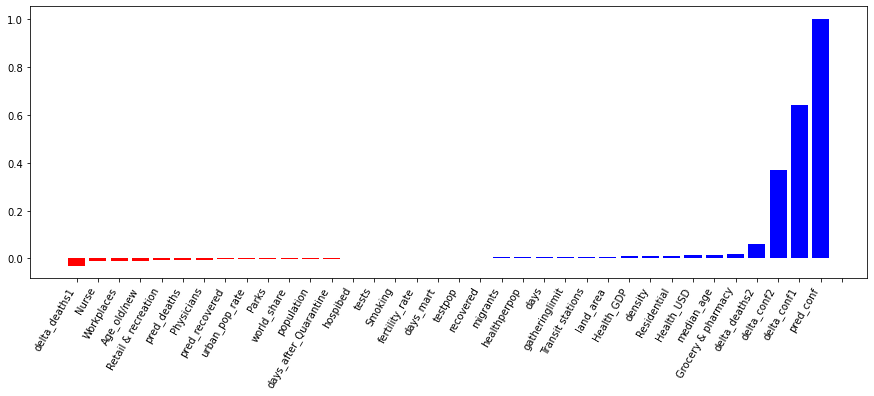

In [22]:
model_Confirmed["Ridge"] = linear_model.Ridge().fit(train_data, train_labels)
model_Death["Ridge"] = linear_model.Ridge().fit(train_data, train_death)
visualize_coefficients(model_Confirmed["Ridge"], train_data.columns)
#del model_Confirmed["Ridge"]

### Lasso

In [0]:
model_Confirmed["Lasso"] = linear_model.Lasso().fit(train_data, train_labels)
model_Death["Lasso"] = linear_model.Lasso().fit(train_data, train_death)

### SGDRegressor

In [0]:
model_Confirmed["SGDRegressor"] = linear_model.SGDRegressor().fit(train_data, train_labels)
model_Death["SGDRegressor"] = linear_model.SGDRegressor().fit(train_data, train_death)

## Нейронная сеть

### Обучаем MLPRegressor

In [0]:

model_Confirmed["MLPRegressor"] = MLPRegressor(hidden_layer_sizes=(100, 100),max_iter=5000,
                                 learning_rate_init=0.01, random_state=0,
                                 early_stopping=True).fit(train_data, train_labels)
                                                            
model_Death["MLPRegressor"] = MLPRegressor(hidden_layer_sizes=(100, 100),max_iter=5000,
                                 learning_rate_init=0.01, random_state=0,
                                 early_stopping=True).fit(train_data, train_death)
                               

### Обучаем Keras

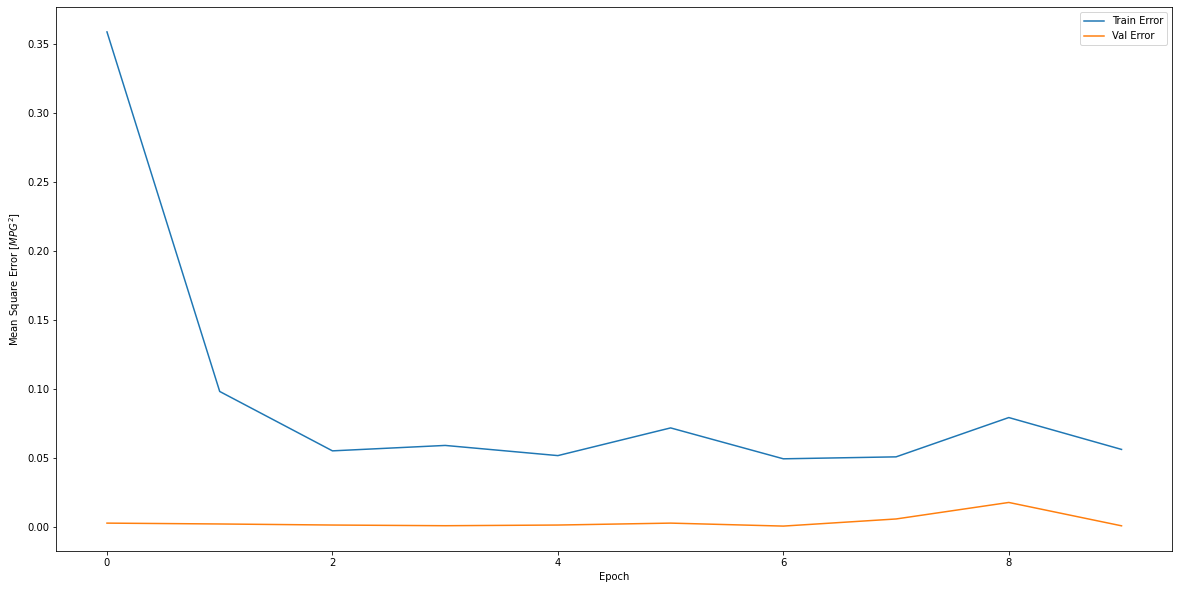

In [27]:
def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_data.keys())]),
    keras.layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dropout(0.2),    
    layers.Dense(1)
  ])
  model.compile(loss='mse', optimizer='adam', metrics='mse')
  return model

EPOCHS = 10
model_Confirmed["keras"] = build_model()
history = model_Confirmed["keras"].fit(train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0)
model_Death["keras"] = build_model()
history = model_Death["keras"].fit(train_data, train_death, epochs=EPOCHS, validation_split = 0.2, verbose=0)
plt.rcParams['figure.figsize'] = [20, 10]
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [$MPG^2$]')
plt.plot(hist['epoch'], hist['mse'], label='Train Error')
plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
plt.legend()


### Обучаем Pytorch

In [28]:

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(len(train_data.keys()), 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = F.relu(self.fc2(x))
    x = F.dropout(x, p=0.2)
    x = self.fc3(x)
    return x
  def predict(self, data):
    pred_y = self(data)
    return pred_y.detach().numpy()[:,0]

model_Confirmed["pytorch"] = Net()

X = Variable(torch.tensor(train_data.values)).float()
target = Variable(torch.tensor(train_labels.to_numpy().reshape(-1,1))).float()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_Confirmed["pytorch"].parameters(), lr = 0.005)
epochs = 200
for epoch in range(epochs):
  net_out = model_Confirmed["pytorch"](X)
  loss = criterion(net_out, target)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if (epoch + 1) % (epochs / 10) == 0:
      print('epoch {}, loss {}'.format(epoch, loss.item()))
model_Confirmed["pytorch"].eval()      

model_Death["pytorch"] =Net()
target = Variable(torch.tensor(train_death.to_numpy().reshape(-1,1))).float()
for epoch in range(epochs):
  net_out = model_Death["pytorch"](X)
  loss = criterion(net_out, target)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
model_Death["pytorch"].eval()


epoch 19, loss 0.12482250481843948
epoch 39, loss 0.08072398602962494
epoch 59, loss 0.058902908116579056
epoch 79, loss 0.05264817178249359
epoch 99, loss 0.0543462410569191
epoch 119, loss 0.03987991437315941
epoch 139, loss 0.04272211715579033
epoch 159, loss 0.04450666159391403
epoch 179, loss 0.039728160947561264
epoch 199, loss 0.0421375036239624


Net(
  (fc1): Linear(in_features=36, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)

## Бустинг и Лес

### Обучаем случайный лес

In [29]:
param_grid = {
    'n_estimators': [200], #Больше - лучше
    'max_depth':[5, 10, 15]
                }
RandomForest1 = ensemble.RandomForestRegressor(random_state=42)
model_Confirmed["RandomForest"] = model_selection.GridSearchCV(estimator = RandomForest1, param_grid = param_grid, 
                                         cv = 3, n_jobs = -1).fit(train_data, train_labels)
model_Death["RandomForest"] = model_selection.GridSearchCV(estimator = RandomForest1, param_grid = param_grid, 
                                         cv = 3, n_jobs = -1).fit(train_data, train_labels)
model_Confirmed["RandomForest"].best_params_


{'max_depth': 5, 'n_estimators': 200}

### Обучаем xgboost

In [0]:

model_Confirmed["Xgboost"] = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=200, max_depth=30, random_state=42,
                                              n_jobs = -1).fit(train_data, train_labels)
model_Death["Xgboost"] = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=200, max_depth=30, random_state=42,
                                          n_jobs = -1).fit(train_data, train_death)
                               

### Обучаем Adaboost Regressor

In [31]:
treeDepth = 10
mdl = tree.DecisionTreeRegressor(max_depth=treeDepth)
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.01],
    'loss' : ["exponential"]
                }
regrMdl = ensemble.AdaBoostRegressor(base_estimator=mdl)
model_Confirmed["Adaboost"] = model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, 
                                         cv = 3, n_jobs = -1).fit(train_data, train_labels)
model_Death["Adaboost"] = model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, 
                                         cv = 3, n_jobs = -1).fit(train_data, train_death)
model_Confirmed["Adaboost"].best_params_

{'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 100}

### Catboost

In [32]:
model_Confirmed["catboost"] = CatBoostRegressor(iterations=100, depth=10,  l2_leaf_reg = 1, verbose=False).fit(train_data, train_labels) 
model_Death["catboost"] = CatBoostRegressor(iterations=100, depth=10, verbose=False).fit(train_data, train_death)
print(model_Confirmed["catboost"].get_all_params())


{'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 100, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 1, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 0, 'depth': 10, 'border_count': 254, 'classes_count': 0, 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.029999999329447743, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 1, 'bootstrap_type': 'MVS', 'max_leaves': 1024}


### Lightgbm

In [0]:

params = {'min_data': 10}
d_train = lgb.Dataset(train_data, label=train_labels)
model_Confirmed["lightgbm"]  = lgb.train(params, d_train, 100)
d_train = lgb.Dataset(train_data, label=train_death)
model_Death["lightgbm"]  = lgb.train(params, d_train, 100)


## Обучаем свою модель

In [0]:
#model_Confirmed["new"] = 
#model_Death["new"] = 

# Считаем ошибку MALE и строим графики

## Функция

In [0]:
def pred_score(models, data, death = False, plot = 0):
  predictions_all = 0
  plt.rcParams['figure.figsize'] = [20, len(models)*10]
  data = data[data.confirmed > 0]
  if not len(data):
    return False
  death_labels = 10**3 * data.deaths
  labels = 10**4 * data.confirmed   
  data = data.drop([ 'iso_alpha3','confirmed','countries','deaths'], axis='columns')  
  
  for i, model in enumerate(models):
    if model == "pytorch":
      predictions = models[model].predict(torch.tensor(data.values).float())
    else:
      predictions = models[model].predict(data).flatten()
  
    if death:
      predictions = 10**3*predictions
    else:
      predictions = 10**4*predictions
    predictions_all = predictions_all + predictions 

    if death:
      MALE = "Ошибка MALE по смертям " + model + " " + str(np.mean(np.abs(np.log10((predictions+1)/(death_labels+1)))))
    else:
      MALE = "Ошибка MALE по заражениям " + model + " " +  str(np.mean(np.abs(np.log10((predictions+1)/(labels+1)))))
    print(MALE)
    if plot:
      plt.subplot(len(models), 1, i+1)
      if plot==1:
        plt.plot(predictions, label = "Предсказанное значение") 
        if death:
          plt.plot(death_labels.values, label = "Истинное значение")
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Смерти')
        else:
          plt.plot(labels.values, label = "Истинное значение")  
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Заражения')
      if plot==2:
        plt.scatter(np.arange(0,len(predictions),1), predictions, s = 1, label = "Предсказанное значение") 
        if death:
          plt.scatter(np.arange(0,len(predictions),1), death_labels.values, s = 1,  label = "Истинное значение")
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Смерти')
        else:
          plt.scatter(np.arange(0,len(predictions),1), labels.values, s = 1,  label = "Истинное значение")  
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Заражения')      
      plt.title(MALE)
      plt.grid(True)
      plt.legend() 
  predictions_all = predictions_all/len(models)
  if death:
    print("Ошибка MALE по смертям средняя", np.mean(np.abs(np.log10((predictions_all+1)/(death_labels+1)))))
  else:
    print("Ошибка MALE по заражениям средняя", np.mean(np.abs(np.log10((predictions_all+1)/(labels+1)))))      

## График + Ошибка MALE

Ошибка MALE по заражениям Ridge 0.1448996235131326
Ошибка MALE по заражениям Lasso 0.6342874896886146
Ошибка MALE по заражениям SGDRegressor 0.0381492999163686
Ошибка MALE по заражениям MLPRegressor 0.33928479885258667


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ошибка MALE по заражениям keras 0.4687936814686101
Ошибка MALE по заражениям pytorch 0.4177897934304818
Ошибка MALE по заражениям RandomForest 0.1739073859679489


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Ошибка MALE по заражениям Xgboost 0.5285622681378241
Ошибка MALE по заражениям Adaboost 0.06267286698112519
Ошибка MALE по заражениям catboost 0.5924750406521571
Ошибка MALE по заражениям lightgbm 0.3246031891818111
Ошибка MALE по заражениям средняя 0.3758881917348181


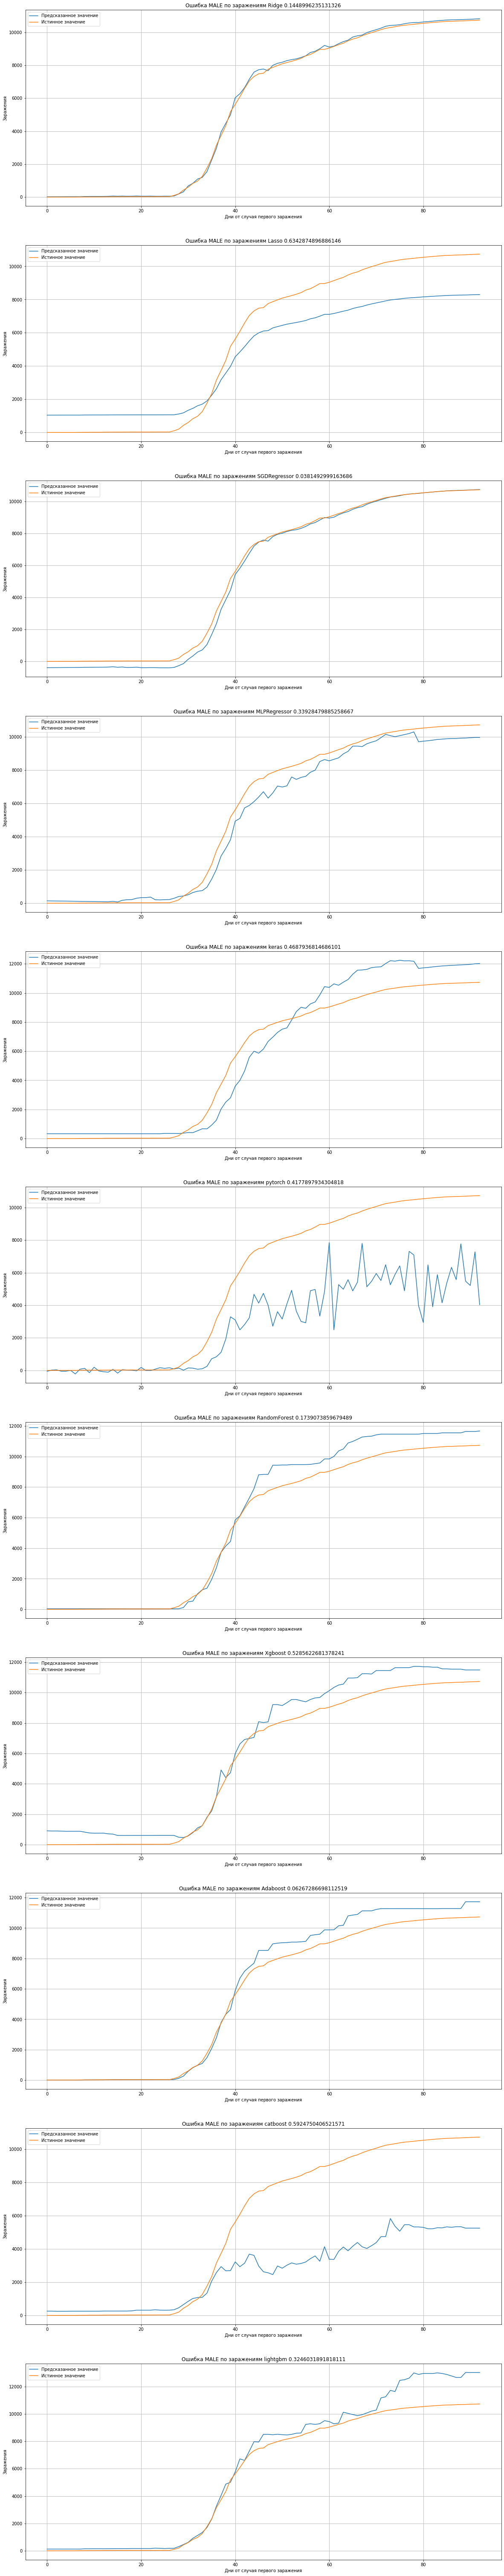

In [36]:
# Данные new_data - новые с дня Х, 
# data_Russia - Данные по России
# data_Korea  - Данные по Франции
data_pred = data_Korea 

# Тип графика 
# 0 - без графика
# 1 - plot
# 2 - scatter
plot_type = 1

#Строим для заражений, или смертей 0.00316
death_bool = False
if death_bool:
  model = model_Death
else:
  model = model_Confirmed

pred_score(model, data_pred, death_bool, plot_type)

#Предсказываем новые данные

In [0]:
#del model_Confirmed["pytorch"]

## Функция отображения данных

In [0]:
def plot_new(list_countries, Matrix, Death = False,subplot_x = 2, days_before = 10, point = True):
  dat2 = data2.copy()
  plt.rcParams['figure.figsize'] = [20, len(list_countries)*20/subplot_x**2]
  dat2.deaths = 10**3*dat2.deaths
  dat2.confirmed = 10**4*dat2.confirmed  
  for i, Country in enumerate(list_countries):
    plt.subplot(len(list_countries)// subplot_x + 1, subplot_x, i+1)
    yyy = dat2.loc[(dat2.iso_alpha3 == Country)&(dat2.confirmed>0)&(dat2.days_mart>=(days_x - days_before)/sc_days)]
    if Death:
      if point:
        plt.plot(yyy.date, yyy.deaths, label = "Истинное значение", marker='o')
        ax = plt.gca()
        for x,y,i in zip(yyy.date,yyy.deaths,range(0,len(yyy))):
          if not i % ((subplot_x * (days_before+days_prog))//20):
            plt.annotate(int(y), (x,y), textcoords="offset points", xytext=(-5,10), ha="right", va = "bottom")
      plt.plot(yyy.date, yyy.deaths, label = "Истинное значение")
      plt.gca().set(xlabel='Дата', ylabel='Смерти')
    else:
      if point:
        plt.plot(yyy.date, yyy.confirmed, label = "Истинное значение", marker='o')
        ax = plt.gca()
        for x,y,i in zip(yyy.date,yyy.confirmed,range(0,len(yyy))):
          if not i % ((subplot_x * (days_before+days_prog))//20):
            plt.annotate(int(y), (x,y), textcoords="offset points", xytext=(-5,10), ha="right", va = "bottom")
      else:
        plt.plot(yyy.date, yyy.confirmed, label = "Истинное значение")
      plt.gca().set(xlabel='Дата', ylabel='Заражения')
    for name in Matrix:
      yyy2 = Matrix[name].loc[:,[Country]]
      if point:
        plt.plot(yyy2, label = name, marker='o')
        ax = plt.gca()
        for x,y,i in zip(yyy2.index,yyy2.values.T[0],range(0,len(yyy2))):
          if not i % ((subplot_x * (days_before+days_prog))//20):
            plt.annotate(int(y), (x,y), textcoords="offset points", xytext=(5,-10), ha="left", va = "top")
      else:
        plt.plot(yyy2, label = name)
    plt.title(dic_countries[Country])
    plt.xticks(np.arange(0, (days_before+days_prog), ((days_before+days_prog)//20)*subplot_x))
    #plt.yticks(np.linspace(0,10+days_prog,30//subplot_x))
    plt.grid(True)
    plt.legend()

## Расчёт значений

In [0]:
# Сколько дней прогнозируем?
days_prog = 15    #264
podgon = True

Matrix_confirmed,Matrix_Death ={},{}
data_list = pd.date_range('2020-04-'+str(days_x-32), periods = days_prog+1, freq ='d')
data_list = data_list.strftime('%#m-%#d') 
new_data_list = data_x.copy()
labels = new_data_list.iso_alpha3
Matrix_confirmed["Среднее"] = pd.DataFrame(np.zeros((days_prog+1, len(labels))),columns = labels,index = data_list)
Matrix_Death["Среднее"] = pd.DataFrame(np.zeros((days_prog+1, len(labels))),columns = labels,index = data_list)

for model_name in model_Confirmed:
  new_data_list = data_x.copy()
  labels = new_data_list.iso_alpha3
  predictions_confirmed = [(new_data_list.pred_conf*10**4).tolist()]
  predictions_Death = [(new_data_list.pred_deaths*10**3).tolist()]        
  new_data_list = new_data_list.drop(['iso_alpha3','confirmed','countries','deaths'], axis='columns')  
  for _ in range(days_prog):
    if model_name == "pytorch":
      prediction_confirmed = model_Confirmed[model_name].predict(torch.tensor(new_data_list.values).float())
      prediction_Death = model_Death[model_name].predict(torch.tensor(new_data_list.values).float())
    else:
      prediction_confirmed = model_Confirmed[model_name].predict(new_data_list).flatten()
      prediction_Death = model_Death[model_name].predict(new_data_list).flatten()

    if podgon:
      bad_confirmed = prediction_confirmed<new_data_list["pred_conf"]
      prediction_confirmed[bad_confirmed] = new_data_list.loc[bad_confirmed,"pred_conf"]+np.round(new_data_list.loc[bad_confirmed,"delta_conf1"]*0.9)
      bad_Death = prediction_Death<new_data_list["pred_deaths"]
      prediction_Death[bad_Death] = new_data_list.loc[bad_Death,"pred_deaths"]+np.round(new_data_list.loc[bad_Death,"delta_deaths1"]*0.9)

    if ('delta_deaths3' in new_data_list.columns):
      new_data_list["delta_deaths3"] = new_data_list["delta_deaths2"]
    if ('delta_deaths2' in new_data_list.columns):
      new_data_list["delta_deaths2"] = new_data_list["delta_deaths1"]
    new_data_list["delta_deaths1"] = prediction_Death - new_data_list["pred_deaths"] 
    
    if ('days_mart' in new_data_list.columns):  
      new_data_list["days_mart"] += 1/sc_days
    if ('days' in new_data_list.columns):
      new_data_list["days"] += 1/sc_days
    if ('days_after_Quarantine' in new_data_list.columns):
      new_data_list['days_after_Quarantine'] += 1/sc_days
    if ('days_after_Quarantine' in new_data_list.columns and 'days_after_Quarantine_bool' in new_data_list.columns):
      new_data_list.loc[new_data_list["days_after_Quarantine"]>14,"days_after_Quarantine_bool"] = 1

 
    if ('recovered' in new_data_list.columns) and ('pred_recovered' in new_data_list.columns):
      new_data_list["recovered"] = new_data_list["recovered"] - new_data_list["pred_recovered"] + new_data_list["recovered"]*0.95
    
    new_data_list["pred_deaths"] = prediction_Death
    new_data_list["pred_conf"] = prediction_confirmed
    prediction_Death = 10**3*prediction_Death 
    prediction_confirmed = 10**4*prediction_confirmed

    prediction_confirmed[prediction_confirmed>10**7] = 10**7
    prediction_Death[prediction_Death>10**6] = 10**6      
    predictions_Death.append(np.round(prediction_Death))
    predictions_confirmed.append(np.round(prediction_confirmed))
   
  Matrix_confirmed[model_name] = pd.DataFrame(predictions_confirmed,columns = labels,index = data_list)
  Matrix_Death[model_name] = pd.DataFrame(predictions_Death,columns = labels,index = data_list)
  Matrix_confirmed["Среднее"] += Matrix_confirmed[model_name]
  Matrix_Death["Среднее"] += Matrix_Death[model_name]
Matrix_confirmed["Среднее"] = Matrix_confirmed["Среднее"]//len(model_Confirmed)
Matrix_Death["Среднее"] = Matrix_Death["Среднее"]//len(model_Confirmed)

## Строим график

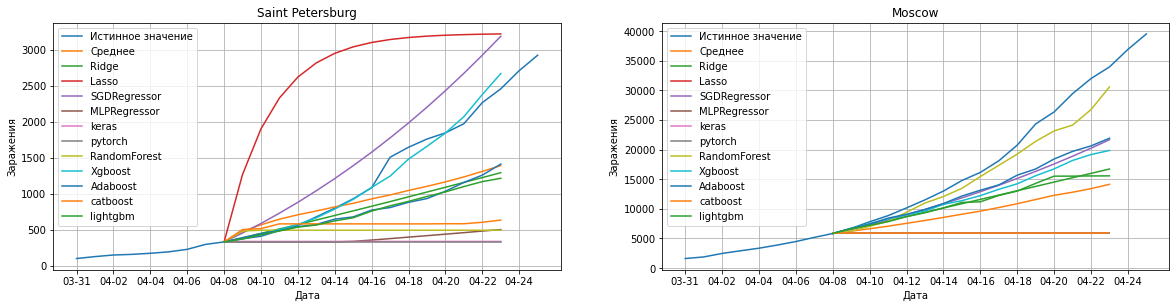

In [40]:
# Создаём список стран
#list_countries = countries.iso_alpha3.to_list()[29:30]
list_countries = []
list_countries.extend(["RU-SPE","RU-MOW"])
#list_countries.extend(["DEU"])

# Количество графиков в строке
subplot_x = 2

# Отмечать точки
point = False

#За сколько дней до начала прогноза
days_before = 10

#Строим для заражений, или смертей
death_bool = False 
if death_bool:
  Matrix = Matrix_Death
else:
  Matrix = Matrix_confirmed
#Matrix = {"Adaboost": Matrix["Adaboost"]}
plot_new(list_countries, Matrix, death_bool, subplot_x, days_before, point)

In [43]:
Matrix_confirmed.keys()

dict_keys(['Среднее', 'Ridge', 'Lasso', 'SGDRegressor', 'MLPRegressor', 'keras', 'pytorch', 'RandomForest', 'Xgboost', 'Adaboost', 'catboost', 'lightgbm'])

# Сохраняем прогноз

In [0]:
ans = Matrix_confirmed["Среднее"].stack().reset_index()
ans_Death = Matrix_Death["Среднее"].stack().reset_index()
ans["prediction_deaths"] = ans_Death[0]
ans.columns = ['date','region','prediction_confirmed', 'prediction_deaths']
ans['date'] = pd.to_datetime('2020-'+ans['date'])
ans['prediction_confirmed'] = ans['prediction_confirmed'].astype('int')
ans['prediction_deaths'] = ans['prediction_deaths'].astype('int')
ans.sort_values(by=['region', 'date']).to_csv('submission.csv', index=False)